## Introduction

This notebook investigates the idealized behavior and breakdown point of the
simple cash strategy in a trading account:

**Target margin usage is a linear function of the drawdown.**

The main idea behind this strategy is to codify "buy low, sell high" as
directly as possible, by borrowing money to buy stock in proportion to its
drawdown.

For our purposes we assume we hold a single share of a security with initial
price of 1. Assuming we trade continuously and can hold continuous fractions of
a share, we will investigate the following question:

**Following the strategy above, what does the shares vs. drawdown graph look like?**

*CAVEAT: actual differential (i.e. price-reversible) trading
can't make money. Therefore, strategy must be very sensitive to discretization
parameters together with the statistics of the underlying price price process.
We ignore these irrelevant details to focus on mathematical purity.*

### Setup

Before proceeding, let's introduce some fundamental variables


$p$, dollars: the price, with initial price $p_0$

$s$, unit: the shares held

$L$, dollars: loan, or negative cash. $L < 0$ means we hold cash

$E_0$, dollars: the initial equity of the account at $p_0$

$r$, unit: the fractional margin requirement

### Defining Margin Usage

First, we need to define what exactly we mean by "margin usage". One natural
definition is as follows:

**Margin usage = maintenance margin / liquidation value**


$v \equiv \frac{rsp}{sp - L}$

This has the property that when we're 100% cash, margin usage is
zero; when we're at zero cash, margin usage is equal to $r$, the
margin requirement, and when we're at the point of liquidation it's
equal to $1$. We have:

$ v \in [0, 1] $

However, for our strategy it is more natural to think of zero margin
usage as the $L = 0$ point, remaining equal to 1 at liquidation.
We don't care as much about what the usage is defined as at all-cash. To this end, we formally define our strategy in terms of
To this end, we define the **modified margin usage** $u$:

$ u \equiv \frac {v - r} {1 - r} $

We get

$ u = \frac r {1 - r} \frac {L} {sp - L} \equiv \beta \frac L {sp - L}$

Where we defined the helper varible $\beta$ as $\frac r {1 - r}$. This variable
goes to zero as $r$ does, but goes to infinity as $r \rightarrow 1$
, so it's similar in spirit to a "Lorentz Factor" for margin, where
$r = 1$ is the speed of light.


$ u \in [-\frac r {1-r}, 1]$

Our strategy of margin usage proportional to drawdown can be stipulated
as:

$ \text{strategy: } u \leftarrow a + bq$

where $a, b$ are parameters we choose. Here we use $\leftarrow$ to mean that
we trade continously to maintain the relationship above.

### The Problem

We can now define the problem:

$\text{problem: solve for } s(p) \text{ from } p = p_0 \text { down }$

This problem is determined by two equations:

(1) The margin state equation, relating drawdown to margin utilization:

$u = β \frac L {sp - L}$

(2) Cash-stock balance -- changes in cash pay/are paid for by selling stock at $p$:

$\diff s u = \frac 1 p \diff L u$

These (together with the strategy $u(p)$) solve for the two unknowns $s(p)$
and $L(p)$

Unfortunately, the differential nature of (2) makes it a bit messy. Sympy will
help us:

In [753]:
import sympy as sp; sp.init_printing(use_latex='mathjax')
# introduce the symbols from above
u, a = sp.symbols('u, a', real=True)
s, b, p, p0, β, E0 = sp.symbols('s b p p0 \\beta E0', real=True, positive=True)

# functions for symbolic calculus
L_ = sp.Function("L", real=True)
s_ = sp.Function("s", real=True, positive=True)
u_ = sp.Function("u")

dldp = L_(p).diff(p)
dsdp = s_(p).diff(p)

u_expr = β * L_(p) / (s_(p) * p - L_(p))
l_expr = sp.solve(sp.Eq(u_(p), u_expr), L_(p))[0]
s_expr = sp.solve(sp.Eq(u_(p), u_expr), s_(p))[0]

We proceed as follows. First, differentiate the equation of margin state for
$s$:

In [754]:
sp.Eq(s_(p), s_expr)

       (\beta + u(p))⋅L(p)
s(p) = ───────────────────
              p⋅u(p)      

In [755]:
dsdp_expr = s_expr.diff(p).doit().factor()
sp.Eq(dsdp, dsdp_expr)

                          d                       d                           
           - \beta⋅p⋅L(p)⋅──(u(p)) + \beta⋅p⋅u(p)⋅──(L(p)) - \beta⋅L(p)⋅u(p) +
d                         dp                      dp                          
──(s(p)) = ───────────────────────────────────────────────────────────────────
dp                                                       2  2                 
                                                        p ⋅u (p)              

    2    d                2   
 p⋅u (p)⋅──(L(p)) - L(p)⋅u (p)
         dp                   
──────────────────────────────
                              
                              

Then eliminate $\diff L p$ using the cash flow equation $\diff L p = p \diff s p$:

In [756]:
dsdp_expr = dsdp_expr.subs(dldp, p * dsdp).doit().simplify()
seq = sp.Eq(0, dsdp - dsdp_expr).simplify()
seq

        d                     d                               
  \beta⋅──(s(p))   \beta⋅L(p)⋅──(u(p))                        
        dp                    dp         \beta⋅L(p)   L(p)    
- ────────────── + ─────────────────── + ────────── + ──── = 0
       u(p)                 2              2            2     
                         p⋅u (p)          p ⋅u(p)      p      

And then eliminate $L(p)$ by once again using our margin state:

In [757]:
sp.Eq(L_(p), l_expr)

       p⋅s(p)⋅u(p) 
L(p) = ────────────
       \beta + u(p)

In [758]:
seq = seq.subs(L_(p), l_expr).doit().simplify()
seq

                         d                       d                            
- \beta⋅p⋅(\beta + u(p))⋅──(s(p)) + \beta⋅p⋅s(p)⋅──(u(p)) + (\beta + u(p))⋅s(p
                         dp                      dp                           
──────────────────────────────────────────────────────────────────────────────
                               p⋅(\beta + u(p))⋅u(p)                          

          
)⋅u(p)    
          
────── = 0
          

Finally we can substitute our strategy $u(p) = a + b \frac {p_0 - p}{p_0}$

In [759]:
u_strat = a + b * (p0 - p) / p
seq = seq.subs(u_(p), u_strat).doit().simplify()
seq

                            2                               d                 
-\beta⋅b⋅p⋅p₀⋅s(p) - \beta⋅p ⋅(-b⋅(p - p₀) + p⋅(\beta + a))⋅──(s(p)) + (a⋅p - 
                                                            dp                
──────────────────────────────────────────────────────────────────────────────
                                     p⋅(a⋅p - b⋅(p - p₀))⋅(-b⋅(p - p₀) + p⋅(\b

                                                  
b⋅(p - p₀))⋅(-b⋅(p - p₀) + p⋅(\beta + a))⋅s(p)    
                                                  
────────────────────────────────────────────── = 0
eta + a))                                         

All that's left to do is call the solver with our initial conditions, which
are given by $s(p_0) = \frac {E_0 - L(p_0)} {p_0}$

In [760]:
L0 = l_expr.subs(u_(p), u_strat).subs(p, p0).simplify()
ics_rhs = (E0 - L0) / p0
s0 = sp.solve(sp.Eq(s_(p0), ics_rhs), s_(p0))[0]
sp.Eq(s_(p0), s0)

         E₀⋅(\beta + a) 
s(p₀) = ────────────────
        p₀⋅(\beta + 2⋅a)

In [761]:
out = sp.dsolve(
    seq,
    ics={s_(p0): s0}
).doit().simplify()
out

           -\beta + a - b          a           b                              
           ──────────────   -1 - ─────       ─────                            
               \beta             \beta       \beta                            
       E₀⋅p              ⋅p₀          ⋅(ℯ⋅p₀)     ⋅(\beta⋅p + a⋅p - b⋅p + b⋅p₀
s(p) = ───────────────────────────────────────────────────────────────────────
                                          \beta + 2⋅a                         

    -b⋅p₀ 
   ───────
   \beta⋅p
)⋅ℯ       
──────────
          

Isn't it beautiful?! Not exactly winning the elegance awards.

### Exploring the Solution

To get a better understanding of the equation, let's substitute some simplifying
parameters:

 - $a = 0$, zero cash at reference price
 - $β = 1$, or a 50% margin requirement
 - $b = 1$

In [762]:
out.rhs.subs([
    (a, 0), (β, 1), (b, 1),
]).simplify()

       p - p₀
       ──────
         p   
E₀⋅p₀⋅ℯ      
─────────────
       2     
      p      

Intriguing... let's plot what this looks like. To get rid of scale factors
we'll work with unitless price $q \equiv \frac p {p_0}$ and unitless shares
$\sigma = s \frac {p_0} {E_0}$. It's important to remark that shares here do *not*
have unity units: if they did, the notion of equity could not be distinguished
cash. Rather, shares have equity "volume" units $[E]$ that need to be normalized.
Price has units $\frac {[\$]}{[E]} $), like density.

In [763]:
q = sp.symbols('q', real=True, positive=True)
σ_ = sp.Function('\\sigma', real=True, positive=True)

normed = sp.Eq(σ_(q), out.rhs.subs(p, q * p0) / E0 * p0).doit().simplify()
normed

               a       b                                b        b   
        -1 + ───── - ─────                            ───── - ───────
             \beta   \beta                            \beta   \beta⋅q
       q                  ⋅(\beta⋅q + a⋅q - b⋅q + b)⋅ℯ               
σ(q) = ──────────────────────────────────────────────────────────────
                                \beta + 2⋅a                          

We'll plot the number of shares from double the reference price to zero.

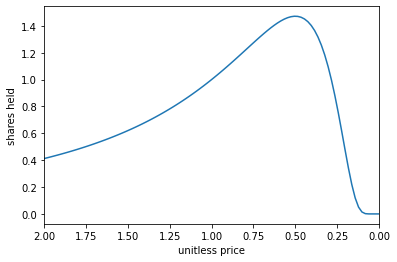

In [764]:
import matplotlib.pyplot as plt; import numpy as np
sp_np = sp.lambdify((q, a, b, β), normed.rhs)

_β = _b = 1
_a = 0
my_ps = np.linspace(2, 1e-3, num=100)
my_ss = sp_np(my_ps, _a, _b, _β)

plt.plot(my_ps, my_ss)
plt.xlim(2, 0); plt.xlabel("unitless price"); plt.ylabel("shares held")
plt.show()

What do we see here?

Going down in price, we keep buying shares
as our target margin utilization increases, all the way up to a breakdown point.
There, the decrease in our equity drives us toward liquidation, and we are
are forced to start selling to maintain our (still increasing) target usage.
This breakdown point looks to be an important risk/reward decision point for
this kind of strategy. Past the breakdown, the collapse is precipitous.

Going up in price, we gradually sell shares off, but slower than
we might expect. Did we not claim that $u = -β$ should be an "all-cash"
utilization? But in this solution no such point exists! What's going on? The
trick is that that utilization was "all cash" for instantaneous reallocation
at our initial equity. Here, as the price increases, so does our equity -- we
sell ever-more appreciated shares, yielding more cash than we started with, but
also maintaining a higher maintenance margin, which pushes the "all-cash" point
ever farther away.

#### Looking at $r$

We can vary the margin requirement $r$ to see what happens. The transformation
to beta is very straightforward.

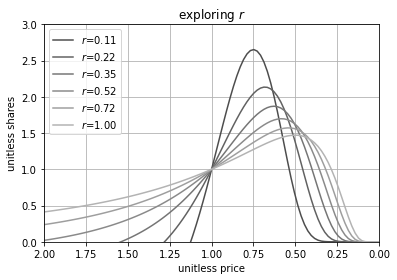

In [765]:
_b = 1; _a = 0
for r in np.linspace(0.1, 0.5, num=6):
    _β = r / (1 - r)
    my_ss = sp_np(my_ps, _a, _b, _β)
    plt.plot(my_ps, my_ss, label=f"$r$={_β:.2f}", color=(r + .2,) * 3)
plt.legend(); plt.title("exploring $r$"); plt.grid()
plt.xlim(2, 0); plt.ylim(0, 3), plt.xlabel("unitless price"); plt.ylabel("unitless shares")
plt.show()

We can see that lower margin requirements without changing $a$ or $b$ make the
strategy extreme, with a breakdown drawdown of around 30% for very low
requirements. We see also that with lower requirements we do reach a zero-cash
point.

#### Looking at $b$
Let's pick a realistic $r$ of 0.25. What do we get by varying the drawdown
coefficient $b$?

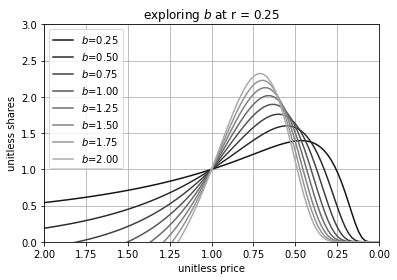

In [766]:
_β = 1/3; _a = 0
for _b in np.linspace(0.25, 2.0, num=8):
    my_ss = sp_np(my_ps, _a, _b, _β)
    plt.plot(my_ps, my_ss, label=f"$b$={_b:.2f}", color=(_b / 3,) * 3)
plt.legend(); plt.title("exploring $b$ at r = 0.25"); plt.grid()
plt.xlim(2.0, 0); plt.ylim(0, 3), plt.xlabel("unitless price"); plt.ylabel("unitless shares")
plt.show()

With $a = 0$ we see that $b$ is very close to being a redundant parameter --
so close, we wish it was! In absolute terms, the cliff is less sensitive to
$b$ than it is to $r$.

#### Looking at $a$
Let's look at $a$, keeping $r=0.25$ and fixing $b = 1$. $a$ controls how
much margin we use at the reference price, and can be either negative or
positive. Its valid range is bounded between $-\beta$ and 1.

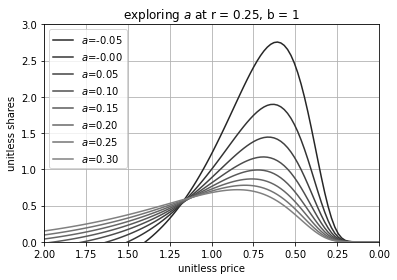

In [767]:
_β = 1/3; _b = 1
for _a in np.linspace(-0.05, 0.3, num=8):
    my_ss = sp_np(my_ps, _a, _b, _β)
    plt.plot(my_ps, my_ss, label=f"$a$={_a:.2f}", color=(0.2 + _a,) * 3)
plt.legend(); plt.title("exploring $a$ at r = 0.25, b = 1"); plt.grid()
plt.xlim(2, 0); plt.ylim(0, 3), plt.xlabel("unitless price"); plt.ylabel("unitless shares")
plt.show()

A is unique among the parameters in that it can adjust the number of
shares held at the reference price, and can make the strategy far less aggressive.
How does $a$ behave together with $b$? We should explore them together by
finding an expression for the height and price of the breakdown point:

In [ ]:
# breakdown = sp.solve(sp.Eq(0, normed.rhs.diff(q).subs(β, 1).subs(a, 0)), q)
# breakdown
diff = normed.rhs.diff(q).doit().simplify()
roots = sp.solve(sp.Eq(0, diff), q)
roots

In [ ]:
np_diff = sp.lambdify((q, a, b, β), diff)
my_ds = np_diff(my_ps, -0.15, 0.5, 0.2)
plt.plot(my_ps, my_ds)
plt.xlim(2, 0)
plt.show()

